In [1]:
import glob
import joblib
import matplotlib.pyplot as plt
import munch
import numpy as np
import os
import sys
import toml
import torch
import torch.nn as nn
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

sys.path.append('../resources/library')
import tropical_cyclone as tc
from tropical_cyclone.tester import GraphTester

## Select results folder

In [2]:
run_dir = '../experiments/graphunet'

## Configuration file parsing

In [3]:
# set the dataset to work on
patches_dir = '../data/patches/test'

# get configuration filename
config_file = os.path.join(run_dir, 'configuration.toml')

# parse config parameters
config = munch.munchify(toml.load(config_file))

# setup scaler
scaler = joblib.load(config.dir.scaler)

# data
drivers = config.data.drivers
targets = config.data.targets

# train parameters
batch_size = config.train.batch_size

## Dataset and DataLoader setup

In [4]:
dataset = tc.dataset.TCGraphDataset(src=patches_dir, drivers=drivers, targets=targets, scaler=scaler, augmentation=True)

Processing...


	augmentation of test dataset: done!
	N of cyclone patches: 58064
	test set - N of no cyclone patches: 863164
	test dataset created with 921228 elements!
	shape of elements:
		x: torch.Size([1600, 6])
		edge_index: torch.Size([2, 6240])
		y: torch.Size([1600, 1])


Done!


In [5]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## Select model checkpoint

In [6]:
# list all available checkpoints
models = sorted(glob.glob(os.path.join(run_dir, 'checkpoints', '*.ckpt')))
for idx,model_name in enumerate(models):
    print(idx, model_name.split('/')[-1])

0 epoch-0000-val_loss-0.27.ckpt
1 epoch-0000-val_loss-0.35.ckpt
2 epoch-0001-val_loss-0.22.ckpt
3 epoch-0001-val_loss-0.27.ckpt
4 epoch-0002-val_loss-0.19.ckpt
5 epoch-0002-val_loss-0.21.ckpt
6 epoch-0003-val_loss-0.16.ckpt
7 epoch-0004-val_loss-0.12.ckpt
8 epoch-0004-val_loss-0.14.ckpt
9 epoch-0006-val_loss-0.12.ckpt
10 epoch-0007-val_loss-0.12.ckpt
11 epoch-0008-val_loss-0.12.ckpt
12 epoch-0009-val_loss-0.12.ckpt
13 last-v1.ckpt
14 last-v2.ckpt
15 last.ckpt


In [10]:
# pick your model
model_file = models[-1]
model_file

'../experiments/graphunet/checkpoints/last.ckpt'

## Model setup

In [11]:
# set model details
model_cls = eval(config.model.cls)
model_args = dict(config.model.args)

# define device
device = torch.device('cuda')

# define model
model:nn.Module = model_cls(**model_args)
model = model.to(device)

# load state dictionary
state_dict = torch.load(f=model_file, map_location=device)

# load weights into the model
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

## Model inference process

In [12]:
tester = GraphTester(device=device, loader=loader, model=model, n_cyclones=dataset.n_cy, nodes_per_graph=model_args['nodes_per_graph'])
metrics = tester.get_metrics(threshold=0.4)

Testing the model: 100%|██████████| 1800/1800 [10:20<00:00,  2.90batch/s]

Threshold: 0.4
	True  positives: 47996
	False positives: 32655
	True  negatives: 830509
	False negatives: 10068
	Average distance between preds and targets: 13.101
	Accuracy:  0.953624
	Precision: 0.595107
	Recall:    0.826605
	F1 score:  0.692009


## Group plot of some predictions against their ground truth

### Notes:
* Since this is an horizontal plot, it can get messy with too many patch indices to plot.
* You have two ways of retrieving a patch for the plot: the first gets the i-th patch from the dataset, moving it to the CPU memory, so it may give problems if you try to re-run the model inference of this notebook afterwards. The second method gets the patch from the dataloader, plotting the first patch in the batch. You have less control on the patches to plot with the second method.
    1. patch = dataset[indices[i]]
    2. patch = next(iter(loader))

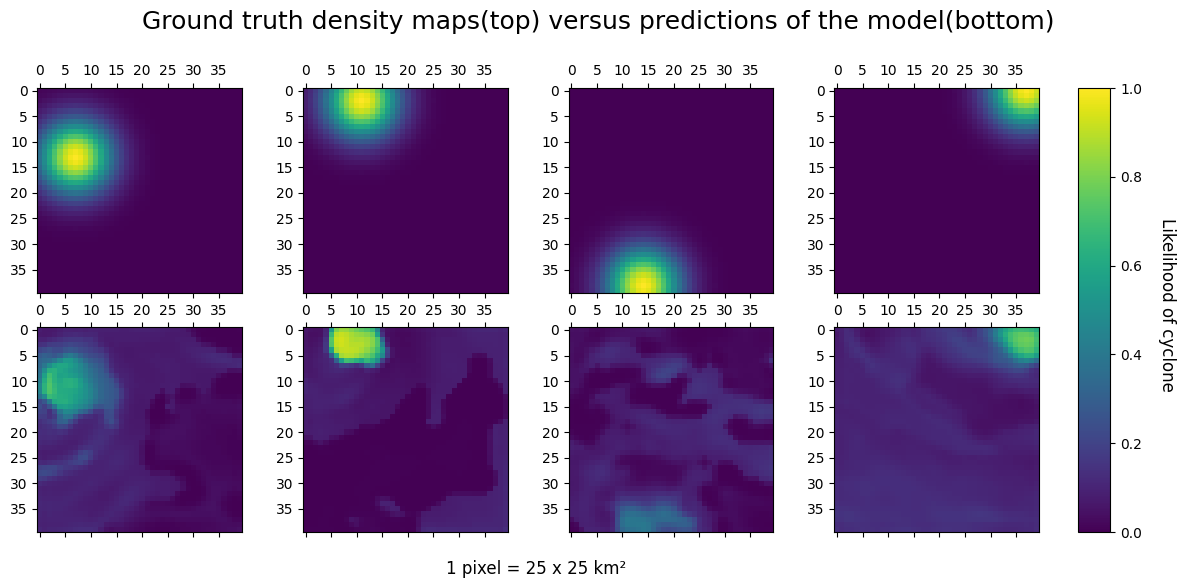

In [13]:
# set the indices of the patches you want to inspect
indices = [110, 10002, 15000, 52]

# set the plot with the right dimensions
fig, axs = plt.subplots(ncols=len(indices), nrows=2, figsize=(16, 6))

with torch.no_grad():
    for i in range(len(indices)):
        patch = dataset[indices[i]]
        patch = patch.to(device)
        pred = model(patch)
        
        # Allocate the empty prediction and target matrices
        mat_pred = np.zeros(shape=(40, 40))
        mat_target = np.zeros(shape=(40, 40))
    
        # Fill the grids
        index = 0
        for lon in range(40):
            for lat in range(40):
                mat_pred[lat, lon] = pred[index].item()
                mat_target[lat, lon] = patch.y[index].item()
                index += 1
    
        ax_target = axs[0][i].matshow(mat_target, vmin=0, vmax=1)
        ax_pred = axs[1][i].matshow(mat_pred, vmin=0, vmax=1)
    
    # add general x and y labels
    fig.text(0.455, 0.04, '1 pixel = 25 x 25 km²', fontsize=12)
    fig.text(0.9, 0.35, 'Likelihood of cyclone', rotation=270, fontsize=12)
    
    # adjust horizontal spacing, vertical spacing and padding of title
    plt.subplots_adjust(hspace=0.17, wspace=-0.4, top=0.85)
    
    cbar_ax = fig.add_axes([0.85, 0.11, 0.02, 0.74])
    fig.colorbar(ax_target, cax=cbar_ax)
    
    # suptitle
    fig.suptitle('Ground truth density maps(top) versus predictions of the model(bottom)', fontsize=18, x=0.55)
    
    plt.show()

## Bits of code that help retrieving the 40x40 coordinates from a prediction

In [ ]:
id_max = np.unravel_index(np.argmax(mat_pred), mat_pred.shape)
id_max

In [ ]:
id_max = np.unravel_index(np.argmax(mat_target), mat_target.shape)
id_max

In [ ]:
value, id_max = torch.max(pred, 0)
value, id_max

In [ ]:
max_x = id_max%40
max_y = id_max//40
max_x, max_y